In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import string
import seaborn as sns
from scipy import stats
import spacy
import matplotlib.pyplot as plt

With the data acquisition process complete after pulling our dataset containing the musical attributes of 10 thousand songs across 5 distinct genres through Spotify and subsequently pulling in the lyrics through Genius by searching each record and scraping the lyrics, we now have a dataframe that has just about all the information we will need to proceed with exploratory data analysis and predictive modeling. However, since we are working with text data with regards to the lyrics, we will first need to apply NLP (Natural Language Processing) techniques in order to clean our text data and present it in a format that will be more accessible to analyze visually and apply machine learning techniques to. We will use a few popular NLP pre-processing Python packages including NLTK, Spacy, Gensim, and RegEx along the way. 

In [5]:
#Read in dataframe from Spotify Data Extraction section containing musical attributes
spotify_df = pd.read_csv('spotify_genre_df.csv')

First off, we will review the lyrical data of our first record in order to determine what potential pre-processing techniques need to be applied.

In [3]:
pd.set_option('display.max_colwidth', -1)
spotify_df['lyrics'][0]

'[Produced by Rick Rubin]\n\n[Verse 1]\nGettin\' born in the state of Mississippi\nPoppa was a copper and her momma was a hippie\nIn Alabama, she would swing a hammer\nPrice you gotta pay when you break the panorama\nShe never knew that there was anything more than poor\nWhat in the world, what does your company take me for?\nBlack bandana, sweet Louisiana\nRobbin\' on a bank in the state of Indiana\nShe\'s a runner, rebel and a stunner\nOn her merry way sayin\', "Baby, what you gonna—?"\nLookin\' down the barrel of a hot metal .45\nJust another way to survive\n\n[Chorus]\nCalifornia, rest in peace\nSimultaneous release\nCalifornia, show your teeth\nShe\'s my priestess, I\'m your priest, yeah, yeah\n\n[Verse 2]\nShe\'s a lover, baby and a fighter\nShoulda seen her comin\' when it got a little brighter\nWith a name like Dani California\nDay was gonna come when I was gonna mourn ya\nA little loaded she was stealin\' another breath\nI love my baby to death\n\n[Chorus]\nCalifornia, rest in

As shown above, there are a few easy fixes we will need to make to start off. The first of this is that all the lyrics include new line markets '\n' in between each line of the lyrics as listed on the Genius website as a result of the HTML formatting that the Lyrics Genius wrapper scraped from. We will address this by applying the regular expression library function 're.sub'. This essentially acts as a find and replace that can be applied to any expression. In our case we will specify the string to find as '\n' and replace it with a single space in order to keep words separated. Below this is applied to all rows in the dataframe using a for loop against the dataframe index.

In [4]:
%%capture
#There are new line markers in the plain text from the html scraping - remove these using a string replace with space
for i in spotify_df.index:
    spotify_df['lyrics'][i] = re.sub("\\n", " ", spotify_df['lyrics'][i])

In [5]:
spotify_df['lyrics'][0]

'[Produced by Rick Rubin]  [Verse 1] Gettin\' born in the state of Mississippi Poppa was a copper and her momma was a hippie In Alabama, she would swing a hammer Price you gotta pay when you break the panorama She never knew that there was anything more than poor What in the world, what does your company take me for? Black bandana, sweet Louisiana Robbin\' on a bank in the state of Indiana She\'s a runner, rebel and a stunner On her merry way sayin\', "Baby, what you gonna—?" Lookin\' down the barrel of a hot metal .45 Just another way to survive  [Chorus] California, rest in peace Simultaneous release California, show your teeth She\'s my priestess, I\'m your priest, yeah, yeah  [Verse 2] She\'s a lover, baby and a fighter Shoulda seen her comin\' when it got a little brighter With a name like Dani California Day was gonna come when I was gonna mourn ya A little loaded she was stealin\' another breath I love my baby to death  [Chorus] California, rest in peace Simultaneous release Cal

After applying the function and reviewing the updated dataframe by checking the first row of lyrics, we can see that the new line markers have been successfully replaced. The next replacement we make is to remove the song section labels (ie. Verse, Chorus, Bridge, etc). We could choose to leave these markers in the lyrics, but considering they are not actually part of the raw text of the lyrics and could affect potential metrics such as word count and word frequency adversely, we will remove these by using a similar RegEx substitution. This would be tricky, but fortunately all of the section markers appear to be surrounded by square brackets (ie. '[Verse]') while there do not appear to be any square brackets around actual lyrics. As such, we can use the regular expression to remove all characters that are within square brackets and replace it with nothing, effectively deleting them.

In [6]:
%%capture
##There are song markers for sections of the lyrics (ie. verse, chorus, bridge, etc.) that can be removed
for i in spotify_df.index:
    spotify_df['lyrics'][i] = re.sub('\[.*?\]', '',spotify_df['lyrics'][i])

In [7]:
spotify_df['lyrics'][0]

'   Gettin\' born in the state of Mississippi Poppa was a copper and her momma was a hippie In Alabama, she would swing a hammer Price you gotta pay when you break the panorama She never knew that there was anything more than poor What in the world, what does your company take me for? Black bandana, sweet Louisiana Robbin\' on a bank in the state of Indiana She\'s a runner, rebel and a stunner On her merry way sayin\', "Baby, what you gonna—?" Lookin\' down the barrel of a hot metal .45 Just another way to survive   California, rest in peace Simultaneous release California, show your teeth She\'s my priestess, I\'m your priest, yeah, yeah   She\'s a lover, baby and a fighter Shoulda seen her comin\' when it got a little brighter With a name like Dani California Day was gonna come when I was gonna mourn ya A little loaded she was stealin\' another breath I love my baby to death   California, rest in peace Simultaneous release California, show your teeth She\'s my priestess, I\'m your pr

After successfully removing the song section markers and verifying, the lyrical data is beginning to look just about clean as far as having complete words and no filler text. One additional step we will take is to remove all punctuation in order to preserve word meanings and prevent a single word from being counted twice (ex. 'what' and 'what?') as a result of a punctuation following it. We have a list of possible punctuations built into Python's string function methods which we can use to do this. Below you can see all the possible punctuation marks it contains. However, since apostrophes (') and hyphens (-) can potentially affect the meaning of certain words (ie. he'll, word-of-mouth), we will exclude these from the list of characters to remove and use the Pandas translate function to replace the rest.

In [8]:
##Check list of Python string stored punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
%%capture
##Remove all punctuation as per list in string.punctuation EXCEPT hyphens and apostrophe's since they affect word meanings
for i in spotify_df.index:
    spotify_df['lyrics'][i] = spotify_df['lyrics'][i].translate(str.maketrans('','','!"#$%&\()*+,./:;<=>?@[\\]^_`{|}~'))

Now that we have completed pre-processing to the point of removing punctuation and irrevelant text, we can begin to take steps to modify our remaining lyrical text to be better analyzed. While there is no standard as to what pre-processing steps need to be done for any NLP analysis, the most common ones include lowercasing, stemming, lemmatization, word tokenizing, removing stop words, and using counters and vectorizers. These techniques can be applied to any text analysis and be beneficial depending on the type of text. In the case of our current project on lyrical analysis, lowercase conversions, lemmatization, and word tokenizing are best applied. We begin by changing all words in the in each set of lyrics to lowercase using the Pandas lower method.

In [12]:
%%capture
##Change all the words in the lyrics to lowercase in order to standardize and enable named entity recognition
for i in spotify_df.index:
    spotify_df['lyrics'][i] = spotify_df['lyrics'][i].lower()

In [6]:
spotify_df['lyrics'][0]

"   gettin' born in the state of mississippi poppa was a copper and her momma was a hippie in alabama she would swing a hammer price you gotta pay when you break the panorama she never knew that there was anything more than poor what in the world what does your company take me for black bandana sweet louisiana robbin' on a bank in the state of indiana she's a runner rebel and a stunner on her merry way sayin' baby what you gonna— lookin' down the barrel of a hot metal 45 just another way to survive   california rest in peace simultaneous release california show your teeth she's my priestess i'm your priest yeah yeah   she's a lover baby and a fighter shoulda seen her comin' when it got a little brighter with a name like dani california day was gonna come when i was gonna mourn ya a little loaded she was stealin' another breath i love my baby to death   california rest in peace simultaneous release california show your teeth she's my priestess i'm your priest yeah yeah   who knew the ot

The remaining pre-processing steps to take after converting all words to lowercase are all done at the word level and require the words of a document to be separated. In order to do this, we will apply the technique of word tokenizing, which takes a text document delimited by a character (in our case, by a single line space) and separates them into a list of word tokens. We will use the package NLTK which contains a number of different types of tokenizers which separate text into tokens by different metrics. We first attempt to use the basic 'word_tokenize' function and apply it to all rows to add the list of tokens to a new column in our dataframe.

In [16]:
%%capture
spotify_df['lyrics_tokenized'] = np.nan

##Use NLTK word tokenize to examine lyrics column and create word tokens in the form of list in new column
for i in spotify_df.index:
    try:
        spotify_df['lyrics_tokenized'][i] = word_tokenize(spotify_df['lyrics'][i])
    except:
        spotify_df['lyrics_tokenized'][i] = []

In [17]:
spotify_df['lyrics_tokenized'].head(5)

0    [gettin, ', born, in, the, state, of, mississippi, poppa, was, a, copper, and, her, momma, was, a, hippie, in, alabama, she, would, swing, a, hammer, price, you, got, ta, pay, when, you, break, the, panorama, she, never, knew, that, there, was, anything, more, than, poor, what, in, the, world, what, does, your, company, take, me, for, black, bandana, sweet, louisiana, robbin, ', on, a, bank, in, the, state, of, indiana, she, 's, a, runner, rebel, and, a, stunner, on, her, merry, way, sayin, ', baby, what, you, gon, na, —, lookin, ', down, the, barrel, of, a, hot, metal, 45, ...]                                                    
1    [psychic, spies, from, china, try, to, steal, your, mind, 's, elation, an, ', little, girls, from, sweden, dream, of, silver, screen, quotation, and, if, you, want, these, kind, of, dreams, it, 's, californication, it, 's, the, edge, of, the, world, and, all, of, western, civilization, the, sun, may, rise, in, the, east, at, least, it, 's, settled, i

Upon reviewing the first five rows of our newly tokenized columns, it looks like the tokenizer did a fairly adequate job at separating words correctly as we would expect. However, the one issue noticeable is that words that contain apostrophes, whether for contraction purposes (ie. "we'll" to "we" and "'ll") or shortening the pronunciation (ie. "gettin'" to "gettin" and "'"), are separated into tokens by the apostrophe. 

It is arguably subjective to determine whether these should indeed be tokenized into two words. In the case of the contraction particularly, the words are separate but combined together to shorten the length and ease of speech (ie. the word "we'll"  being "we" and "will"). However, in passing when read as  text or even heard in a song, these are phrased as a single word. As such, for the purposes of this project I determined it's best to keep these words together. In order to do this, I did some additional research into other tokenizers NLTK may enable and discovered that the Tweet Tokenizer, which as per it's named is meant to parse Twitter posts into tokens, does the job at tokenizing by separating words by keeping words connected by punctuation together.

In [18]:
%%capture

tknzr = TweetTokenizer()

##Use NLTK Tweet Tokenizer to attempt to tokenize contractions correctly, which were splitting using word tokenize
for i in spotify_df.index:
    try:
        spotify_df['lyrics_tokenized'][i] = tknzr.tokenize(spotify_df['lyrics'][i])
    except:
        spotify_df['lyrics_tokenized'][i] = []

In [23]:
pd.set_option('display.max_colwidth', -1)
spotify_df['lyrics_tokenized'].head(5)

0    [gettin, ', born, in, the, state, of, mississippi, poppa, was, a, copper, and, her, momma, was, a, hippie, in, alabama, she, would, swing, a, hammer, price, you, gotta, pay, when, you, break, the, panorama, she, never, knew, that, there, was, anything, more, than, poor, what, in, the, world, what, does, your, company, take, me, for, black, bandana, sweet, louisiana, robbin, ', on, a, bank, in, the, state, of, indiana, she's, a, runner, rebel, and, a, stunner, on, her, merry, way, sayin, ', baby, what, you, gonna, —, lookin, ', down, the, barrel, of, a, hot, metal, 45, just, another, way, ...]                                                                                  
1    [psychic, spies, from, china, try, to, steal, your, mind's, elation, an, ', little, girls, from, sweden, dream, of, silver, screen, quotation, and, if, you, want, these, kind, of, dreams, it's, californication, it's, the, edge, of, the, world, and, all, of, western, civilization, the, sun, may, rise, in, th

After applying the Tweet Tokenizer in lieu of the the Word Tokenizer, we see that the contraction words have been correctly kept together as a single token. However, the words ending in an apostrophe are still being separated into two tokens. Since we would not want to count an apostrophe as a word, we can use the 'isalpha' method on each token in order to remove tokens such as the apostrophe that is not alpha-numeric.

Beyond this, with our lyric text separated out into tokens we can continue to apply the other pre-processing steps that need to be done at the word level. The first of this was mentioned in removing non-alpha tokens. The second is to remove stop words, which are often defined as commonly used words that search engines that use NLP techniques are designed to ignore. These include pronouns such as "I", "him", "her" and articles such as "The" and "and". These words are likely to be common across all genres and thus not likely to be helpful in helping predict uniqueness across genres. As such, we will create a new column where these words are removed. 

Lastly, we have the techniques of stemming and lemmatization, which take the root of the words using different methods of application. These two techniques are generally mutually exclusive with the choice of using one or the other depending on the situation. For our purposes, we will use lemmatization which benefits from it's ability to retain the original meaning of the word, whereas stemming can often break down words to their root more accurately but sometimes lose the original meaning (ie. "classification" to "class"). 

Since all these techniques will change the word counts and overall lyrical data, we will make them in a new columns named as "lyrics_cleaned" so we can compare the before and after lyrics and apply in our upcoming analysis. Below I applied the three methods of removing non-alpha tokens, stopwords, and lemmatizing the remaining tokens.

In [200]:
%%capture
nltk.download('wordnet', 'stopwords')
spotify_df['lyrics_cleaned'] = np.NaN
lemmatizer = WordNetLemmatizer()
stopwords.words('english')

In [224]:
%%capture
##Change all the words in the lyrics to lowercase in order to standardize and enable named entity recognition
for i in spotify_df[spotify_df['lyrics_cleaned'].isnull()].head(1000).index:
    spotify_df['lyrics_cleaned'][i] = [i for i in spotify_df['lyrics_tokenized'][i] if i.isalpha()]
    spotify_df['lyrics_cleaned'][i] = [i for i in spotify_df['lyrics_cleaned'][i] if not i in stopwords.words('english')]
    spotify_df['lyrics_cleaned'][i] = [lemmatizer.lemmatize(i) for i in spotify_df['lyrics_cleaned'][i]]

In [191]:
pd.set_option('max_colwidth', -1)
spotify_df['lyrics_cleaned'].head(1)

0    [gettin, born, state, mississippi, poppa, copper, momma, hippie, alabama, would, swing, hammer, price, gotta, pay, break, panorama, never, knew, anything, poor, world, company, take, black, bandana, sweet, louisiana, robbin, bank, state, indiana, runner, rebel, stunner, merry, way, sayin, baby, gonna, lookin, barrel, hot, metal, another, way, survive, california, rest, peace, simultaneous, release, california, show, teeth, priestess, priest, yeah, yeah, lover, baby, fighter, shoulda, seen, comin, got, little, brighter, name, like, dani, california, day, gonna, come, gonna, mourn, ya, little, loaded, stealin, another, breath, love, baby, death, california, rest, peace, simultaneous, release, california, show, teeth, priestess, priest, yeah, yeah, knew, side, ...]                                                                              
1    [psychic, spies, china, try, steal, elation, little, girls, sweden, dream, silver, screen, quotation, want, kind, dreams, californication, 

With these final techniques applied, we finally have a dataset which contains a raw text form of the lyrics, a cleaned text form, a tokenized version including all tokens, as well as a cleaned token form. We will now proceed to add a couple additional fields which can help assist in our EDA and ML portion. Given that these words are tokenized and text data, we cannot compare these directly with our other numerical data. However, we can derive numerical data from our text in the form of word counts, which we proceed to do below by taking the length of the list of tokens.

In [24]:
spotify_df['word_count'] = np.nan

In [119]:
%%capture
##Find the total word count of each song by using the len function on the list for each row
for i in spotify_df.index:
    spotify_df['word_count'][i] = len(spotify_df['lyrics_tokenized'][i])

In [27]:
pd.reset_option('display.max_colwidth')
spotify_df.head(5)

,track_name,artist,album,track_id,playlist_name,danceability,energy,full_key,key,mode,...,instrumentalness,liveness,valence,tempo,duration_minutes,duration_ms,time_signature,lyrics,lyrics_tokenized,word_count
0,Dani California,Red Hot Chili Peppers,Stadium Arcadium,10Nmj3JCNoMeBQ87uw5j8k,Rock,0.556,0.913,C Major,C,Major,...,0.000009,0.346,0.730,96.184,4.702667,282160,4,gettin' born in the state of mississippi po...,"[gettin, ', born, in, the, state, of, mississi...",306.0
1,Californication,Red Hot Chili Peppers,Californication (Deluxe Edition),48UPSzbZjgc449aqz8bxox,Rock,0.592,0.767,A Minor,A,Minor,...,0.001650,0.127,0.328,96.483,5.495550,329733,4,psychic spies from china try to steal your mi...,"[psychic, spies, from, china, try, to, steal, ...",286.0
2,The Pretender,Foo Fighters,"Echoes, Silence, Patience & Grace",7x8dCjCr0x6x2lXKujYD34,Rock,0.433,0.959,A Major,A,Major,...,0.000000,0.028,0.365,172.984,4.489550,269373,4,keep you in the dark you know they all preten...,"[keep, you, in, the, dark, you, know, they, al...",461.0
3,Smells Like Teen Spirit,Nirvana,Nevermind (Remastered),5ghIJDpPoe3CfHMGu71E6T,Rock,0.502,0.912,C# Major,C#,Major,...,0.000173,0.106,0.720,116.761,5.032000,301920,4,load up on guns bring your friends it's fun t...,"[load, up, on, guns, bring, your, friends, it'...",249.0
4,Scar Tissue,Red Hot Chili Peppers,Californication (Deluxe Edition),1G391cbiT3v3Cywg8T7DM1,Rock,0.595,0.717,C Major,C,Major,...,0.002740,0.108,0.547,88.969,3.598450,215907,4,scar tissue that i wish you saw sarcastic mis...,"[scar, tissue, that, i, wish, you, saw, sarcas...",248.0


After computing the word counts, we did some quick visual analysis to see what the distribution of word counts is across our dataset. Below you can see a box plot of the word count which visualized the middle 50 percent of the data along with the percentil distribution and any outliers. Somewhat surpringly, there are a considerable amount of serious outliers in the data.

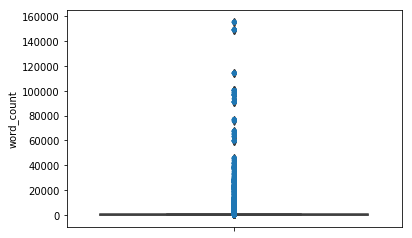

In [48]:
sns.boxplot(y='word_count', data=spotify_df.sort_values(by="word_count", ascending=True))
plt.show()

In [120]:
min_word_count = np.min(spotify_df['word_count'])
med_word_count = np.median(spotify_df['word_count'])
max_word_count = np.max(spotify_df['word_count'])

print("Minimum Word Count:", min_word_count)
print("Median Word Count:", med_word_count)
print("Maximum Word Count:", max_word_count)

Minimum Word Count: 0.0
Median Word Count: 299.0
Maximum Word Count: 155275.0


In [121]:
for i in np.arange(.05, 1.0, .05):
    print(i, ":", spotify_df['word_count'].quantile(i))

0.05 : 0.0
0.1 : 76.0
0.15000000000000002 : 143.0
0.2 : 179.0
0.25 : 203.0
0.3 : 225.0
0.35000000000000003 : 245.0
0.4 : 263.0
0.45 : 281.0
0.5 : 299.0
0.55 : 318.0
0.6000000000000001 : 340.0
0.6500000000000001 : 363.0
0.7000000000000001 : 392.0
0.7500000000000001 : 429.0
0.8 : 484.0
0.8500000000000001 : 555.0
0.9000000000000001 : 663.0
0.9500000000000001 : 825.0


Running some basic summary statistics on our word counts shows a median word count of 299 and a maximum of 155275, clearly a massive discrepancy. I sought to break this down further by determing what percentage of the data is above a certain word count, and did so by breaking down the quantiles by every 5 percent. As shown, 95% of the data contains 825 word tokens or less. As such, I examined a few of the rows with words above that and discovered that the lyrics were pulled incorrectly from the Genius API call, resulting in massive amounts of texts from novels and track listings and other text unrelated to the actual songs. As such, I proceeded to simply clear the lyrics of the top 5 percent of the data since these largely represented outliers and would not be accurate to use for analysis.

In [139]:
#Clear lyrics on the upper 5 percent since they are likely innacurate
spotify_df.loc[spotify_df['word_count'] > 825, 'lyrics'] = ''
spotify_df.loc[spotify_df['word_count'] > 825, 'lyrics_tokenized'] = pd.Series([])
spotify_df.loc[spotify_df['word_count'] > 825, 'word_count'] = 0.0

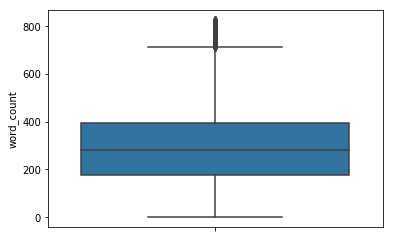

In [146]:
sns.boxplot(y='word_count', data=spotify_df.sort_values(by="word_count", ascending=True))
plt.show()

After clearing the data and visualizing the word counts again via a box plot, we not see a much more reasonable distribution of word counts with the bulk hovering around 200 to 400 words. There still do appear to be outliers in the 700-800 range, but upon spot checking a few of these discovered they are mostly accurate lyrics and true outliers.

In [112]:
for i in spotify_df[spotify_df['lyrics_tokenized'].isnull()].index:
    spotify_df['lyrics_tokenized'][i] = []

/Users/varunraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


With the word count of the original token list generated, I thought it would be useful to also generate a word count of the cleaned dataframe. In addition, another potential measurable metric is to count the unique words in a set of lyrics. As such I computed the quantity of cleaned lyrics tokens as well as unique tokens for both the raw and cleaned versions and updated the dataframe with a column for each.

In [395]:
%%capture
##Find the total word count of each song by using the len function on the list for each row
for i in spotify_df.index:
    spotify_df['word_count'][i] = len(spotify_df['lyrics_tokenized'][i])

In [411]:
%%capture

spotify_df['word_count_unique'] = np.nan

##Find the total word count of each song by using the len function on the list for each row
for i in spotify_df.index:
    spotify_df['lyrics_unique'][i] = len(set(spotify_df['lyrics_tokenized'][i]))

In [ ]:
%%capture

spotify_df['word_count_cleaned'] = np.nan

##Find the total word count of each song by using the len function on the list for each row
for i in spotify_df.index:
    spotify_df['word_count_cleaned'][i] = len(set(spotify_df['lyrics_cleaned'][i]))

In [423]:
%%capture

spotify_df['word_count_cleaned_unique'] = np.nan

##Find the total word count of each song by using the len function on the list for each row
for i in spotify_df.index:
    spotify_df['word_count_cleaned_unique'][i] = len(set(spotify_df['lyrics_cleaned'][i]))

With our datafram just about prepared, in order gain additional insights into potential topics and potentially important words across the sets of all lyrics, we used Spacy's named entity recognition function to add a column including named entity as well as the count.

In [427]:
%%capture

spotify_df['entity_count_unique'] = np.nan

##Find the total word count of each song by using the len function on the list for each row
for i in spotify_df.index:
    spotify_df['entity_count_unique'][i] = len(set(spotify_df['named_entities'][i]))

In [376]:
for i in spotify_df[spotify_df['named_entities'].isnull()].head(1000).index:
    spotify_df['named_entities'][i] = ner(str(spotify_df.iloc[i]['lyrics'])).ents

/Users/varunraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [381]:
pd.reset_option('max_colwidth')
spotify_df[~spotify_df['named_entities'].isnull()].head(5)

,track_name,artist,album,track_id,playlist_name,danceability,energy,full_key,key,mode,...,valence,tempo,duration_minutes,duration_ms,time_signature,lyrics,lyrics_tokenized,word_count,lyrics_cleaned,named_entities
0,Dani California,Red Hot Chili Peppers,Stadium Arcadium,10Nmj3JCNoMeBQ87uw5j8k,Rock,0.556,0.913,C Major,C,Major,...,0.730,96.184,4.702667,282160,4,gettin' born in the state of mississippi po...,"[gettin, ', born, in, the, state, of, mississi...",306.0,"[gettin, born, state, mississippi, poppa, copp...","[(mississippi, poppa), (alabama), (sweet, loui..."
1,Californication,Red Hot Chili Peppers,Californication (Deluxe Edition),48UPSzbZjgc449aqz8bxox,Rock,0.592,0.767,A Minor,A,Minor,...,0.328,96.483,5.495550,329733,4,psychic spies from china try to steal your mi...,"[psychic, spies, from, china, try, to, steal, ...",286.0,"[psychic, spy, china, try, steal, elation, lit...","((china), (sweden), (east), (hollywood), (holl..."
2,The Pretender,Foo Fighters,"Echoes, Silence, Patience & Grace",7x8dCjCr0x6x2lXKujYD34,Rock,0.433,0.959,A Major,A,Major,...,0.365,172.984,4.489550,269373,4,keep you in the dark you know they all preten...,"[keep, you, in, the, dark, you, know, they, al...",461.0,"[keep, dark, know, pretend, keep, dark, began,...",()
3,Smells Like Teen Spirit,Nirvana,Nevermind (Remastered),5ghIJDpPoe3CfHMGu71E6T,Rock,0.502,0.912,C# Major,C#,Major,...,0.720,116.761,5.032000,301920,4,load up on guns bring your friends it's fun t...,"[load, up, on, guns, bring, your, friends, it'...",249.0,"[load, gun, bring, friend, fun, lose, pretend,...",()
4,Scar Tissue,Red Hot Chili Peppers,Californication (Deluxe Edition),1G391cbiT3v3Cywg8T7DM1,Rock,0.595,0.717,C Major,C,Major,...,0.547,88.969,3.598450,215907,4,scar tissue that i wish you saw sarcastic mis...,"[scar, tissue, that, i, wish, you, saw, sarcas...",248.0,"[scar, tissue, wish, saw, sarcastic, mister, c...","((kentucky), (fallin), (ma), (pa), (viewin), (..."


In [308]:
##Load named entities through Spacy and loop through lyrics to create new columns containing list of entities for each song
ner = spacy.load('en', tagger=False, parser=False, matcher=False)

spotify_df['named_entities'] = np.nan

Lastly, in order to see the breakdown of unique tracks, artists, and albums in each genre for potential EDA, I added columns for tracking the count of each of these across genres. Finally we have a dataframe with all the preprocessing complete and necessary metrics built into our dataframe. We will save off the updated dataframe into a CSV and proceed to use it in the next section.

In [ ]:
%%capture

genres = ['Rock', 'Country', 'Hip-Hop', 'Pop', 'Electronic/Dance']
spotify_df['count_artist'] = np.nan
spotify_df['count_track'] = np.nan
spotify_df['count_album'] = np.nan

for genre in genres:
    for i in spotify_df[spotify_df['playlist_name'] == genre].index:  
        spotify_df['count_artist'][i] = spotify_df[spotify_df['playlist_name'] == genre]['artist'].nunique()
        spotify_df['count_track'][i] = spotify_df[spotify_df['playlist_name'] == genre]['track_name'].nunique()
        spotify_df['count_album'][i] = spotify_df[spotify_df['playlist_name'] == genre]['album'].nunique()

In [425]:
#Read dataframe into CSV file to use in the next portion
spotify_df.to_csv("spotify_genre_df_cleaned.csv", index=False)